# Teeth Classification – Week 1 Project
## Introduction
Accurate teeth classification is a critical component of AI-driven dental diagnostic systems.  
In this project, we build a baseline computer vision pipeline that includes image preprocessing, visualization, and training a CNN model to classify dental images into 7 categories.

## Step 0 — Setup & Paths

In [1]:
import gdown

file_id = "1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY"
url = f"https://drive.google.com/uc?id={file_id}"

output = "/kaggle/working/teeth_dataset.zip"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=a71dd7f7-055b-40f8-a7ee-c66721622cf6
To: /kaggle/working/teeth_dataset.zip
100%|██████████| 49.1M/49.1M [00:00<00:00, 133MB/s] 


'/kaggle/working/teeth_dataset.zip'

In [2]:
import zipfile

with zipfile.ZipFile("/kaggle/working/teeth_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/kaggle/working/teeth_dataset")

In [3]:
!ls /kaggle/working/teeth_dataset

Teeth_Dataset


In [4]:
import os

BASE_PATH = "/kaggle/working/teeth_dataset/Teeth_Dataset"

TRAIN_DIR = os.path.join(BASE_PATH, "Training")
VAL_DIR   = os.path.join(BASE_PATH, "Validation")
TEST_DIR  = os.path.join(BASE_PATH, "Testing")

print("Train path:", TRAIN_DIR)
print("Val path:", VAL_DIR)
print("Test path:", TEST_DIR)

Train path: /kaggle/working/teeth_dataset/Teeth_Dataset/Training
Val path: /kaggle/working/teeth_dataset/Teeth_Dataset/Validation
Test path: /kaggle/working/teeth_dataset/Teeth_Dataset/Testing


## Step 1 — Dataset Understanding

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2026-02-05 21:50:02.055578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770328202.399312      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770328202.509200      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770328203.367398      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770328203.367446      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770328203.367449      55 computation_placer.cc:177] computation placer alr

In [6]:
classes = os.listdir(TRAIN_DIR)
num_classes = len(classes)
print('Number of classess: ', num_classes)

class_counts = []
for cls in classes:
    count = len(os.listdir(os.path.join(TRAIN_DIR, cls)))
    class_counts.append(count)
    print(f'{cls}: {count} images')

Number of classess:  7
MC: 540 images
Gum: 360 images
OLP: 540 images
CoS: 450 images
OT: 393 images
CaS: 480 images
OC: 324 images


The dataset contains 7 dental categories with varying sample counts.

### Class Distribution Visualization

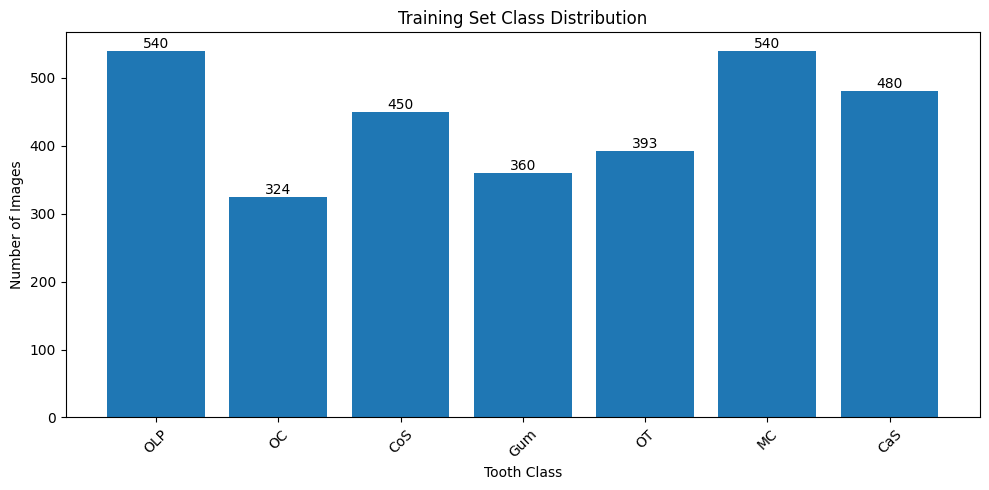

In [7]:
plt.figure(figsize=(10, 5))
bars = plt.bar(classes, class_counts)

plt.title('Training Set Class Distribution')
plt.xlabel('Tooth Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

for bar in bars:
    yvalue = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yvalue, int(yvalue), ha='center', va='bottom')

plt.tight_layout()
plt.savefig("/kaggle/working/class_distribution.png")
plt.show()

### Observation
The training dataset consists of 7 tooth classes with varying numbers of images per class.
While the distribution is relatively balanced, slight differences exist, which could affect
model learning. To mitigate this, data augmentation techniques will be applied in the next stage.

### Sample Images from Each Class

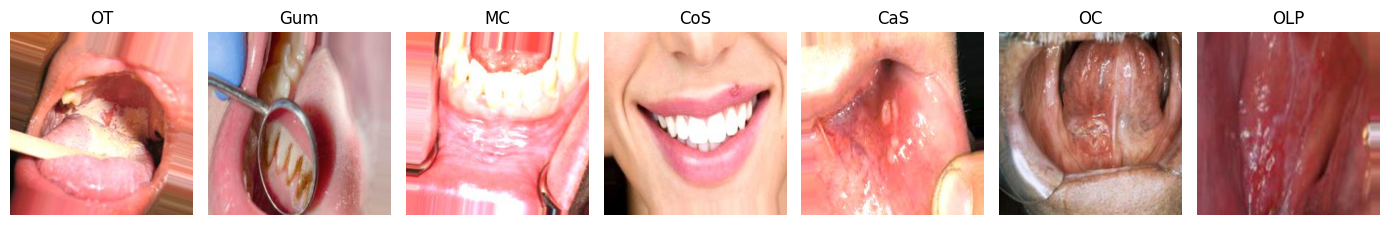

In [7]:
plt.figure(figsize=(14, 8))
for i, cls in enumerate(random.sample(classes,7)):
    img_path = os.path.join(TRAIN_DIR, cls, random.choice(os.listdir(os.path.join(TRAIN_DIR, cls))))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 7, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.savefig("/kaggle/working/raw_samples.png")
plt.show()

## Step 2 — Preprocessing & Augmentation

### 2.1 — Image Preprocessing Setup

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

### 2.2 — Baseline (No Augmentation)

In [9]:
baseline_datagen = ImageDataGenerator(
    rescale=1./255  # Normalization
)

baseline_train_generator = baseline_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

Found 3087 images belonging to 7 classes.


### 2.3 — Augmentation Generator

In [10]:
aug_datagen  = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

aug_train_generator = aug_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

Found 3087 images belonging to 7 classes.


### 2.4 — Validation Generator

In [11]:
val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False
)

Found 1028 images belonging to 7 classes.


## Step 3 — Before / After Augmentation Visualization

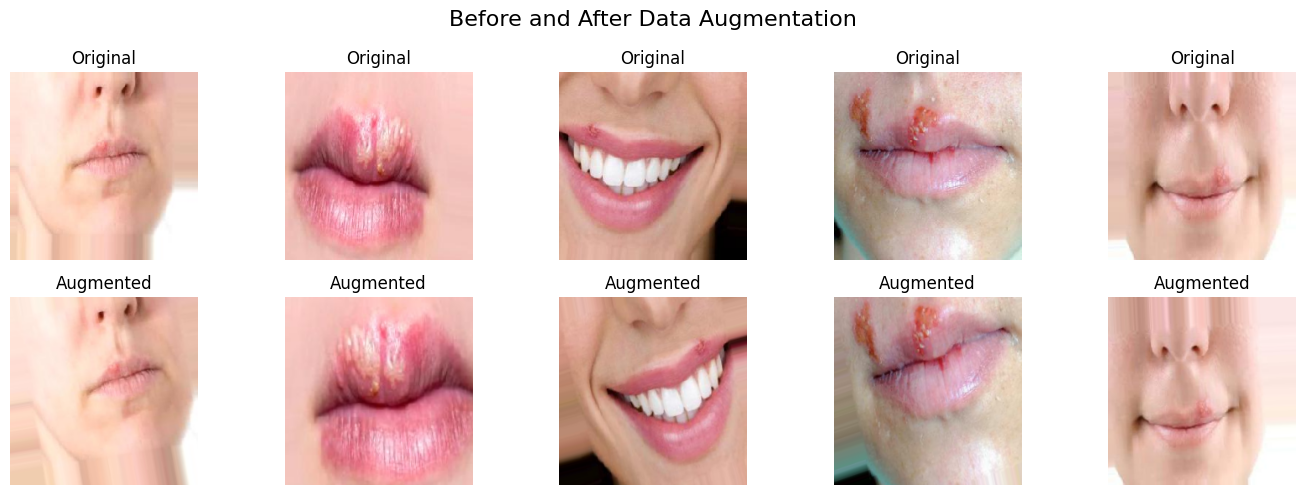

In [15]:
sample_class = random.choice(classes)
sample_imgs = random.sample(os.listdir(os.path.join(TRAIN_DIR, sample_class)), 5)

plt.figure(figsize=(14, 5))

for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(TRAIN_DIR, sample_class, img_name)

     # Original image
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)

    # Augmented image
    img_array_expanded = np.expand_dims(img_array, axis=0)
    aug_img = next(aug_datagen.flow(img_array_expanded, batch_size=1))[0]

     # Plot original
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")
    
    # Plot augmented
    plt.subplot(2, 5, i+6)
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis("off")

plt.suptitle("Before and After Data Augmentation", fontsize=16)
plt.tight_layout()
plt.savefig("/kaggle/working/augmentation.png")
plt.show()

### Preprocessing & Augmentation
Image normalization was applied to scale pixel values to the range [0,1], ensuring stable and efficient training.
Data augmentation techniques such as rotation, zoom, shifting, and horizontal flipping were used to increase dataset diversity and improve model generalization, while preserving the anatomical structure of dental images.


## Step 4 — CLAHE

### 4.1 — CLAHE Function

In [16]:
def apply_clahe(img):
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    image = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

    return image


def preprocessing_with_clahe(img):
    img = apply_clahe(img)
    img = img / 255.0
    return img

### 4.2 — CLAHE + Augmentation

In [17]:
clahe_datagen  = ImageDataGenerator(
    preprocessing_function=preprocessing_with_clahe,    
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

clahe_train_generator = clahe_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

Found 3087 images belonging to 7 classes.


### 4.3 — CLAHE Validation generator

In [18]:
clahe_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_with_clahe,
)

clahe_val_generator = clahe_val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False
)

Found 1028 images belonging to 7 classes.


### 4.4 — CLAHE Visualization

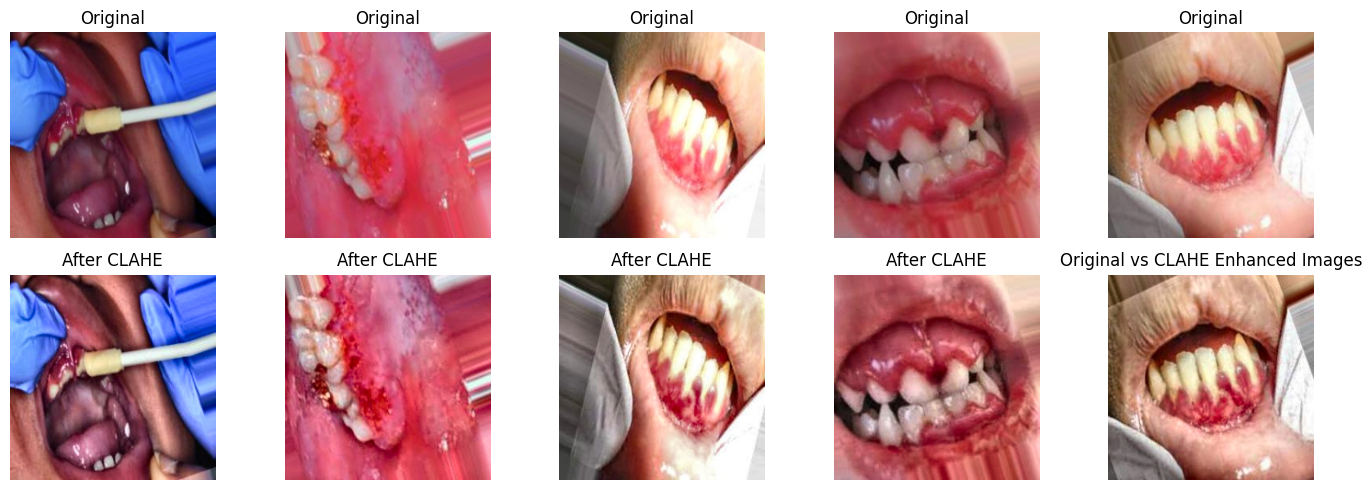

In [20]:
sample_class = random.choice(classes)
sample_imgs = random.sample(os.listdir(os.path.join(TRAIN_DIR, sample_class)), 5)

plt.figure(figsize=(14, 5))

for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(TRAIN_DIR, sample_class, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    # Apply CLAHE
    clahe_img = apply_clahe(img)

    # Original
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    # CLAHE
    plt.subplot(2, 5, i+6)
    plt.imshow(clahe_img)
    plt.title("After CLAHE")
    plt.axis("off")

plt.title(f'Original vs CLAHE Enhanced Images')
plt.tight_layout()
plt.savefig("/kaggle/working/clahe.png")
plt.show()

CLAHE was applied to enhance local contrast and highlight fine dental structures, which are critical for accurate tooth classification. Visual inspection shows improved clarity and better separation between teeth and background.

## Step 5 — Baseline CNN Model

### 5.1 — Baseline Model Function

In [21]:
def build_cnn_model(input_shape=(224, 224, 3), num_classes=7):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))

    # model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    # model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D(2, 2))
    # -----------------------------

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### 5.2 — Callbacks

In [22]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1)
]

## Step 6 — Training

### Model A — Baseline

In [23]:
baseline_model = build_cnn_model(input_shape=(224, 224, 3), num_classes=num_classes)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1770328895.469377      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [24]:
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457,927 (1.75 MB)

 Trainable params: 456,967 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [25]:
baseline_history = baseline_model.fit(
    baseline_train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1770328906.273270     225 service.cc:152] XLA service 0x7f0ddc108040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770328906.273310     225 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770328906.992170     225 cuda_dnn.cc:529] Loaded cuDNN version 91002


 3/97 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.1146 - loss: 2.2316  

I0000 00:00:1770328913.694289     225 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.2915 - loss: 1.8524 - val_accuracy: 0.1449 - val_loss: 4.6245 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.4390 - loss: 1.4710 - val_accuracy: 0.1449 - val_loss: 5.6406 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.4896 - loss: 1.3297 - val_accuracy: 0.1479 - val_loss: 5.4017 - learning_rate: 0.0010
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5316 - loss: 1.2024 - val_accuracy: 0.1907 - val_loss: 4.0571 - learning_rate: 0.0010
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.5838 - loss: 1.1185 - val_accuracy: 0.3161 - val_loss: 2.7356 - learning_rate: 0.0010
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6126 - loss: 1.0422 - val_accuracy: 0.3307 - val_loss: 2.9800 - learning_rate: 0.0010
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6565 - loss: 0.9437 - val_accuracy: 0.

### Model B — Augmentation

In [26]:
aug_model = build_cnn_model(input_shape=(224, 224, 3),num_classes=num_classes)

aug_history = aug_model.fit(
    aug_train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 351ms/step - accuracy: 0.3109 - loss: 1.8788 - val_accuracy: 0.1829 - val_loss: 2.6676 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 313ms/step - accuracy: 0.3809 - loss: 1.5573 - val_accuracy: 0.1459 - val_loss: 4.3144 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 315ms/step - accuracy: 0.4494 - loss: 1.4655 - val_accuracy: 0.1965 - val_loss: 3.4146 - learning_rate: 0.0010
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 313ms/step - accuracy: 0.4672 - loss: 1.4089 - val_accuracy: 0.2412 - val_loss: 2.9649 - learning_rate: 0.0010
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 317ms/step - accuracy: 0.5048 - loss: 1.2673 - val_accuracy: 0.3006 - val_loss: 1.9334 - learning_rate: 0.0010
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 317ms/step - accuracy: 0.5557 - loss: 1.1910 - val_accuracy: 0.4426 - val_loss: 1.6050 - learning_rate: 0.0010
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.5609 - loss: 1.

### Model C — CLAHE + Augmentation

In [27]:
clahe_model = build_cnn_model(input_shape=(224, 224, 3), num_classes=num_classes)

clahe_history = clahe_model.fit(
    clahe_train_generator,
    validation_data=clahe_val_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 450ms/step - accuracy: 0.2985 - loss: 1.8042 - val_accuracy: 0.1449 - val_loss: 4.3944 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 409ms/step - accuracy: 0.4320 - loss: 1.4631 - val_accuracy: 0.1449 - val_loss: 5.5802 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - accuracy: 0.4839 - loss: 1.3223 - val_accuracy: 0.1965 - val_loss: 4.4509 - learning_rate: 0.0010
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 414ms/step - accuracy: 0.5273 - loss: 1.2310 - val_accuracy: 0.1595 - val_loss: 5.2117 - learning_rate: 0.0010
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 411ms/step - accuracy: 0.5753 - loss: 1.1226 - val_accuracy: 0.2451 - val_loss: 3.3262 - learning_rate: 0.0010
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 413ms/step - accuracy: 0.6369 - loss: 1.0013 - val_accuracy: 0.4864 - val_loss: 1.4046 - learning_rate: 0.0010
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 412ms/step - accuracy: 0.6298 - loss: 0.

## Step 7 — Testing

In [29]:
baseline_train_generator.class_indices

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}

In [30]:
valid_classes = list(baseline_train_generator.class_indices.keys())

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=valid_classes,
    shuffle=False
)

clahe_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_with_clahe,
    )

clahe_test_generator = clahe_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=valid_classes,
    shuffle=False
)

Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [31]:
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(test_generator)
print("Test Accuracy:", baseline_test_acc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9795 - loss: 0.0616
Test Accuracy: 0.9688715934753418


In [32]:
aug_test_loss, aug_test_acc = aug_model.evaluate(test_generator)
print("Test Accuracy:", aug_test_acc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9948 - loss: 0.0545
Test Accuracy: 0.9892995953559875


In [33]:
clahe_test_loss, clahe_test_acc = clahe_model.evaluate(clahe_test_generator)
print("Test Accuracy:", clahe_test_acc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9744 - loss: 0.1022 
Test Accuracy: 0.9620622396469116


## Step 8 — Results

In [34]:
results = pd.DataFrame({
    'Model': ['Baseline', 'Augmented', 'CLAHE Enhanced'],
    'Best Acc': [
        max(baseline_history.history['accuracy']),
        max(aug_history.history['accuracy']),
        max(clahe_history.history['accuracy'])
    ],
    'Best Val Acc': [
        max(baseline_history.history['val_accuracy']),
        max(aug_history.history['val_accuracy']),
        max(clahe_history.history['val_accuracy'])
    ],
    'Best Val Loss': [
        min(baseline_history.history['val_loss']),
        min(aug_history.history['val_loss']),
        min(clahe_history.history['val_loss'])
    ],
    'Final Val Acc': [
        baseline_history.history['val_accuracy'][-1],
        aug_history.history['val_accuracy'][-1],
        clahe_history.history['val_accuracy'][-1]
    ],
    'Final Acc': [
        baseline_history.history['accuracy'][-1],
        aug_history.history['accuracy'][-1],
        clahe_history.history['accuracy'][-1]
    ],
    'Final Val Loss': [
        baseline_history.history['val_loss'][-1],
        aug_history.history['val_loss'][-1],
        clahe_history.history['val_loss'][-1]
    ]
})
results.head()

,Model,Best Acc,Best Val Acc,Best Val Loss,Final Val Acc,Final Acc,Final Val Loss
0,Baseline,0.997409,0.984436,0.067429,0.984436,0.995141,0.069521
1,Augmented,0.971817,0.991245,0.059986,0.989300,0.964043,0.060269
2,CLAHE Enhanced,0.942339,0.964981,0.148457,0.964981,0.940395,0.153265


In [36]:
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("/kaggle/working/models_result.png")
    plt.show()

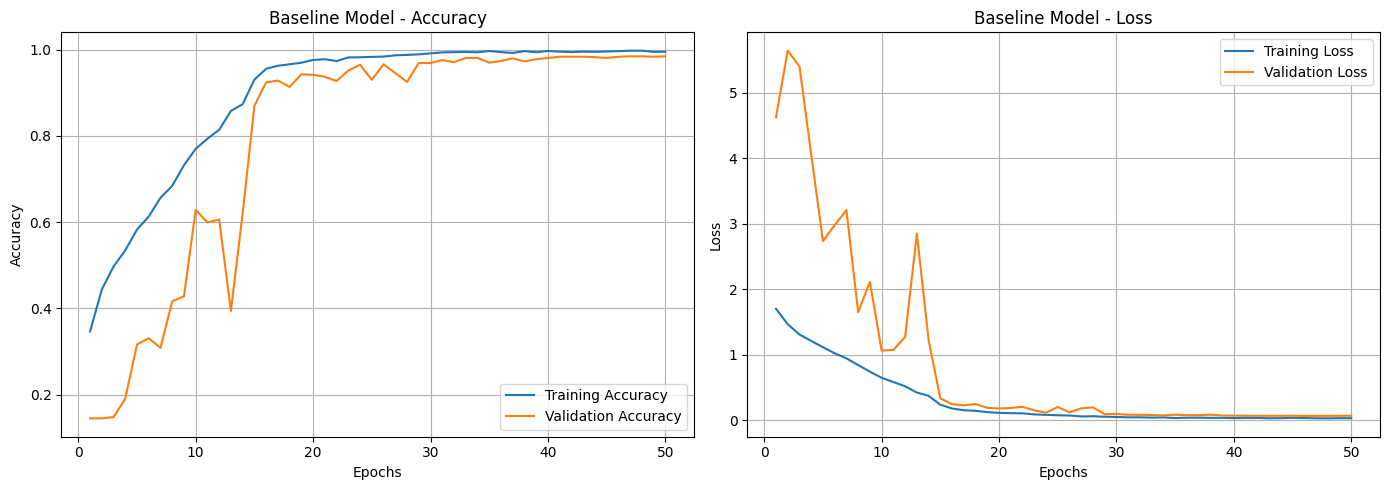

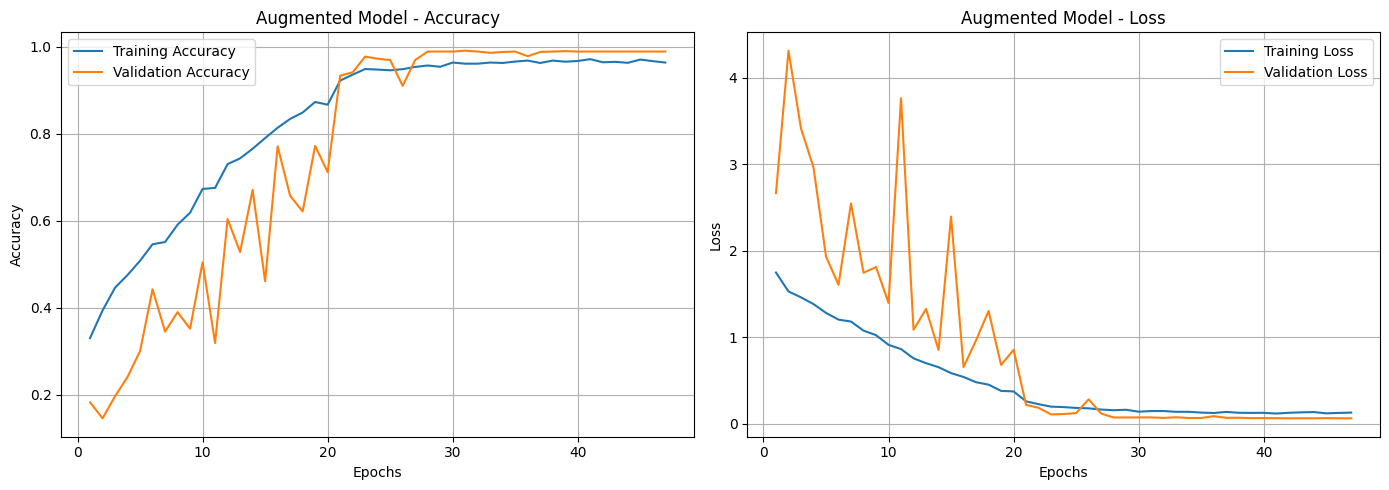

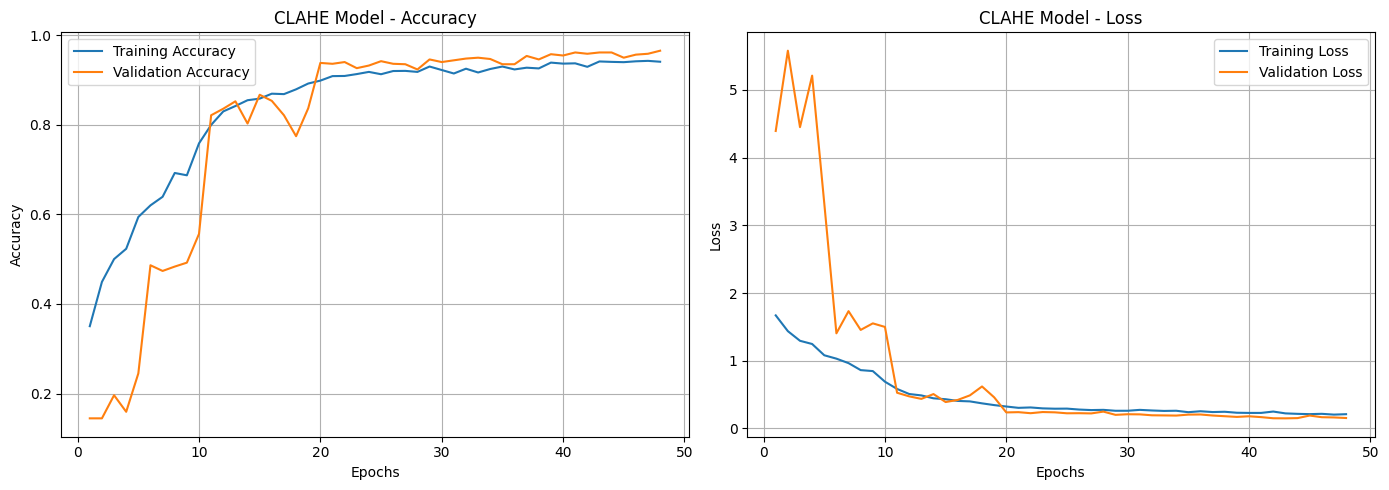

In [37]:
plot_training_history(baseline_history, "Baseline Model")
plot_training_history(aug_history, "Augmented Model")
plot_training_history(clahe_history, "CLAHE Model")

In [38]:
baseline_model.save("best_base_classification_model.h5")

print("Model Saved")

Model Saved


In [39]:
aug_model.save("best_teeth_classification_model.h5")

print("Model Saved")

Model Saved


In [40]:
clahe_model.save("best_clahe_classification_model.h5")

print("Model Saved")

Model Saved


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


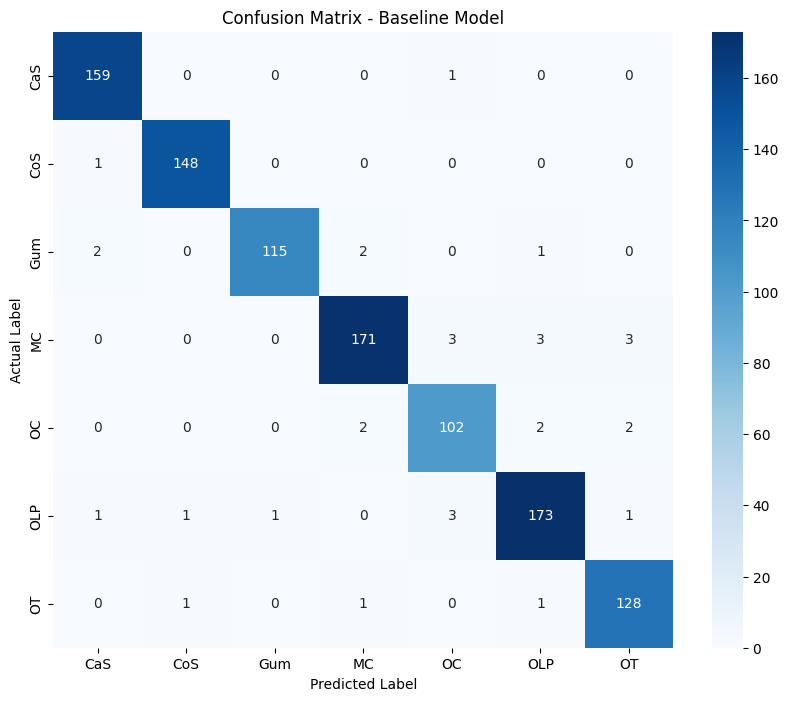


Classification Report:

              precision    recall  f1-score   support

         CaS       0.98      0.99      0.98       160
         CoS       0.99      0.99      0.99       149
         Gum       0.99      0.96      0.97       120
          MC       0.97      0.95      0.96       180
          OC       0.94      0.94      0.94       108
         OLP       0.96      0.96      0.96       180
          OT       0.96      0.98      0.97       131

    accuracy                           0.97      1028
   macro avg       0.97      0.97      0.97      1028
weighted avg       0.97      0.97      0.97      1028



In [48]:
y_pred_probs = baseline_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true = test_generator.classes

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=valid_classes, yticklabels=valid_classes)

plt.title('Confusion Matrix - Baseline Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig("/kaggle/working/baseline_confusion_matrix.png")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=valid_classes))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


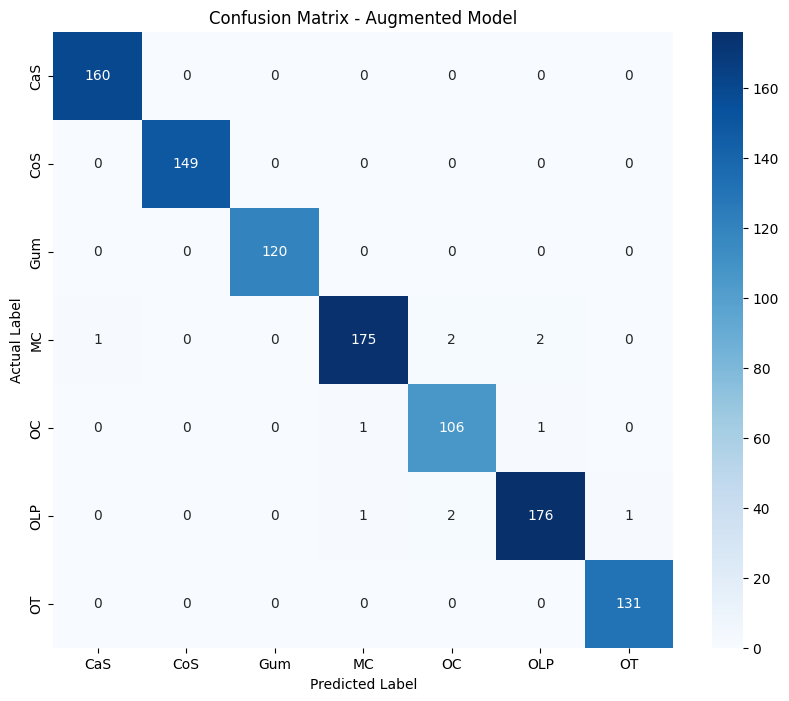


Classification Report:

              precision    recall  f1-score   support

         CaS       0.99      1.00      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       0.99      0.97      0.98       180
          OC       0.96      0.98      0.97       108
         OLP       0.98      0.98      0.98       180
          OT       0.99      1.00      1.00       131

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028



In [49]:
from sklearn.metrics import confusion_matrix,classification_report

y_pred_probs = aug_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true = test_generator.classes

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=valid_classes, yticklabels=valid_classes)

plt.title('Confusion Matrix - Augmented Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig("/kaggle/working/augmented_confusion_matrix.png")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=valid_classes))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


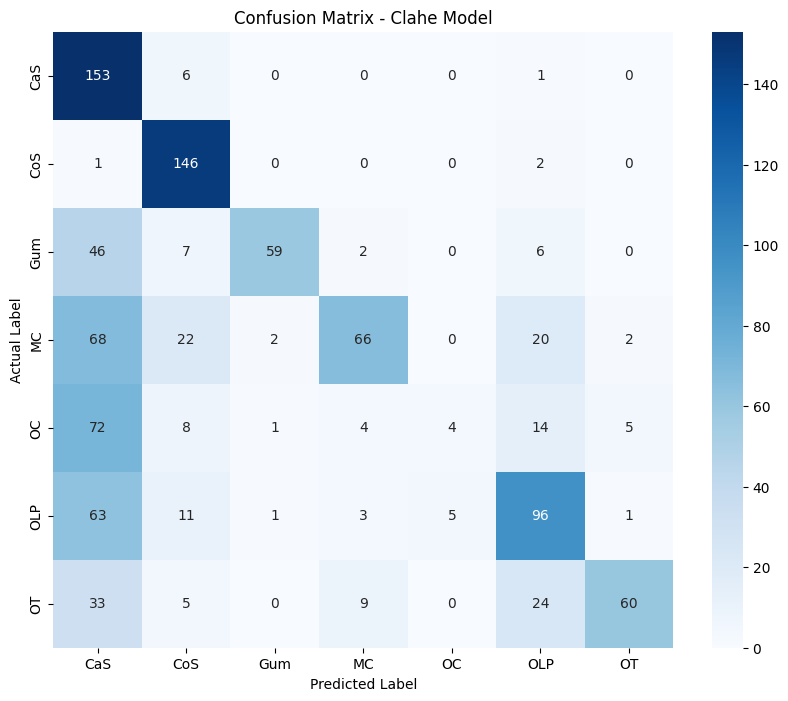


Classification Report:

              precision    recall  f1-score   support

         CaS       0.35      0.96      0.51       160
         CoS       0.71      0.98      0.82       149
         Gum       0.94      0.49      0.64       120
          MC       0.79      0.37      0.50       180
          OC       0.44      0.04      0.07       108
         OLP       0.59      0.53      0.56       180
          OT       0.88      0.46      0.60       131

    accuracy                           0.57      1028
   macro avg       0.67      0.55      0.53      1028
weighted avg       0.67      0.57      0.54      1028



In [50]:
y_pred_probs = clahe_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true = test_generator.classes

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=valid_classes, yticklabels=valid_classes)

plt.title('Confusion Matrix - Clahe Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig("/kaggle/working/clahe_confusion_matrix.png")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=valid_classes))